In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import time
import heapq
import math
import itertools

# Run Network Sims

In [ ]:
ntwk_params1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
ntwk_seeds1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [11]:
ntwk1 = ClusNtwkTriInqGenerator(ntwk_params1, ntwk_seeds1)
ntwk1.createNetwork()

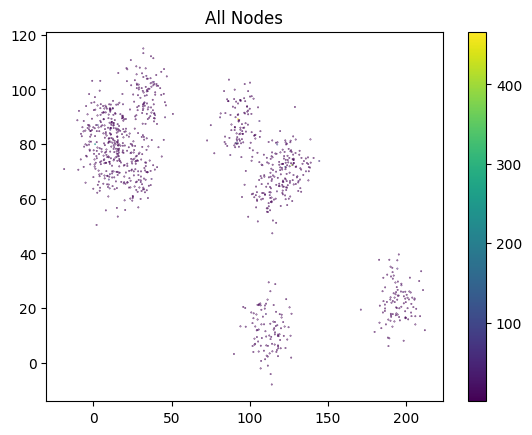

In [12]:
ntwk1.plotAll()

In [ ]:
ntwk_params2 = {
    "n" : 1000,
    "n_clusters" : 20,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
ntwk_seeds2 = {
    "uniform_scatter" : 926,
    "normal_subscatter" : 427,
    "power" : 576,
}

In [14]:
ntwk2 = ClusNtwkTriInqGenerator(ntwk_params2, ntwk_seeds2)
ntwk2.createNetwork()

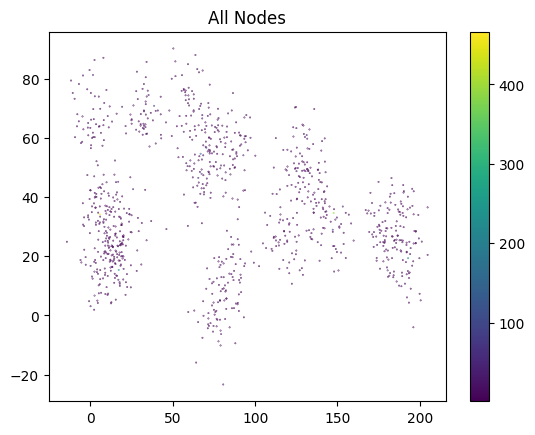

In [15]:
ntwk2.plotAll()

In [ ]:
ntwk_params3 = {
    "n" : 1000,
    "n_clusters" : 30,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
ntwk_seeds3 = {
    "uniform_scatter" : 683,
    "normal_subscatter" : 280,
    "power" : 576,
}

In [17]:
ntwk3 = ClusNtwkTriInqGenerator(ntwk_params3, ntwk_seeds3)
ntwk3.createNetwork()

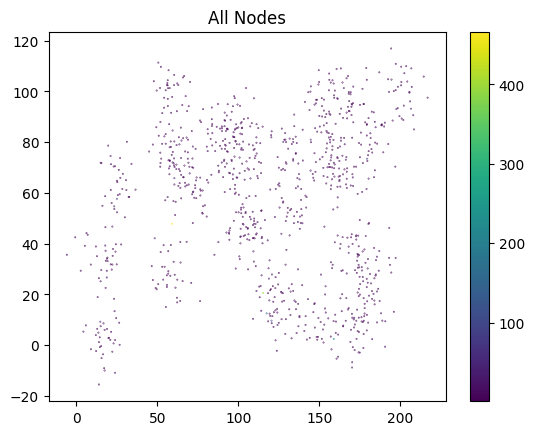

In [18]:
ntwk3.plotAll()

In [ ]:
ntwk_params4 = {
    "n" : 1000,
    "n_clusters" : 40,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
ntwk_seeds4 = {
    "uniform_scatter" : 571,
    "normal_subscatter" : 846,
    "power" : 576,
}

In [20]:
ntwk4 = ClusNtwkTriInqGenerator(ntwk_params3, ntwk_seeds3)
ntwk4.createNetwork()

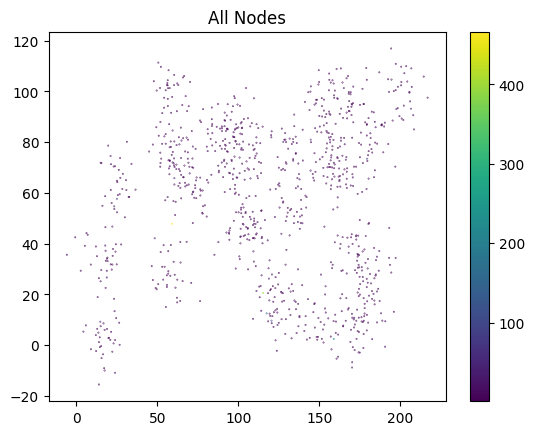

In [21]:
ntwk4.plotAll()

In [22]:
print(ntwk1.getStats())

{'ntwk_total_power': 5161.254346496223, 'ntwk_max_powers': [466.451026562379, 400.5969715981964, 232.6995019748793, 229.54706612596644, 134.94557313586955], 'ntwk_max_power_shares': [0.09037551634691957, 0.07761620426052947, 0.045085842772474495, 0.0444750540693266, 0.02614588704148613], 'ntwk_min_powers': [1.0000120979579032, 1.0014111974069595, 1.0016183766846853, 1.002559501608579, 1.003019572057839], 'ntwk_min_power_shares': [0.0001937536945135775, 0.000194024771921341, 0.0001940649131861997, 0.00019424725741121017, 0.00019433639668208765], 'ntwk_max_bandwidth': [np.float64(48833.00046773377), np.float64(29328.114150154004), np.float64(26831.53534281743), np.float64(24434.026851372113), np.float64(23097.07037310115)], 'ntwk_min_bandwidth': [np.float64(8.393439314543063), np.float64(8.493628420136085), np.float64(8.499902190811307), np.float64(8.54401408541276), np.float64(8.54977560944329)]}


In [23]:
print(ntwk2.getStats())

{'ntwk_total_power': 5161.254346496223, 'ntwk_max_powers': [466.451026562379, 400.5969715981964, 232.6995019748793, 229.54706612596644, 134.94557313586955], 'ntwk_max_power_shares': [0.09037551634691957, 0.07761620426052947, 0.045085842772474495, 0.0444750540693266, 0.02614588704148613], 'ntwk_min_powers': [1.0000120979579032, 1.0014111974069595, 1.0016183766846853, 1.002559501608579, 1.003019572057839], 'ntwk_min_power_shares': [0.0001937536945135775, 0.000194024771921341, 0.0001940649131861997, 0.00019424725741121017, 0.00019433639668208765], 'ntwk_max_bandwidth': [np.float64(96382.13878773156), np.float64(33616.61925734382), np.float64(25740.131721324306), np.float64(14939.456505159842), np.float64(13676.781741708459)], 'ntwk_min_bandwidth': [np.float64(8.891845571530652), np.float64(8.912743669900353), np.float64(8.92933361635299), np.float64(8.944566432947106), np.float64(8.985288032827835)]}


In [24]:
print(ntwk3.getStats())

{'ntwk_total_power': 4863.4313410548375, 'ntwk_max_powers': [466.451026562379, 400.5969715981964, 229.54706612596644, 134.94557313586955, 99.40521262774199], 'ntwk_max_power_shares': [0.09590986154668521, 0.08236920468405548, 0.047198582652588576, 0.027746988427023004, 0.020439316535345975], 'ntwk_min_powers': [1.0000120979579032, 1.0014111974069595, 1.0016183766846853, 1.003019572057839, 1.0042948094083604], 'ntwk_min_power_shares': [0.00020561863175002878, 0.00020590630918411646, 0.0002059489085883636, 0.00020623701697828275, 0.00020649922636525536], 'ntwk_max_bandwidth': [np.float64(25053.94422060036), np.float64(18726.057867113297), np.float64(9639.73545393889), np.float64(9411.902293762507), np.float64(9239.345457252155)], 'ntwk_min_bandwidth': [np.float64(8.531643116727063), np.float64(8.58675108901622), np.float64(8.60857986785463), np.float64(8.625817211691059), np.float64(8.63339303422437)]}


In [25]:
print(ntwk4.getStats())

{'ntwk_total_power': 4863.4313410548375, 'ntwk_max_powers': [466.451026562379, 400.5969715981964, 229.54706612596644, 134.94557313586955, 99.40521262774199], 'ntwk_max_power_shares': [0.09590986154668521, 0.08236920468405548, 0.047198582652588576, 0.027746988427023004, 0.020439316535345975], 'ntwk_min_powers': [1.0000120979579032, 1.0014111974069595, 1.0016183766846853, 1.003019572057839, 1.0042948094083604], 'ntwk_min_power_shares': [0.00020561863175002878, 0.00020590630918411646, 0.0002059489085883636, 0.00020623701697828275, 0.00020649922636525536], 'ntwk_max_bandwidth': [np.float64(25053.94422060036), np.float64(18726.057867113297), np.float64(9639.73545393889), np.float64(9411.902293762507), np.float64(9239.345457252155)], 'ntwk_min_bandwidth': [np.float64(8.531643116727063), np.float64(8.58675108901622), np.float64(8.60857986785463), np.float64(8.625817211691059), np.float64(8.63339303422437)]}


# Run PoW Sims

In [26]:
pow_params1 = {
    "run_time" : 10000,
    "avg_mine_time" : 100,
    "max_n_transactions" : 1000,
    "avg_signal_noise" : 5,
}
pow_seeds1 = {
    "poisson_noise" : None,
    "exponential_minetime" : None
}

In [30]:
sim1 = PoW(ntwk1.getNetwork().copy(), pow_params1, pow_seeds1)
sim1.runSimulation()

In [31]:
pow_params2 = {
    "run_time" : 10000,
    "avg_mine_time" : 100,
    "max_n_transactions" : 1000,
    "avg_signal_noise" : 5,
}
pow_seeds2 = {
    "poisson_noise" : None,
    "exponential_minetime" : None
}

In [32]:
sim2 = PoW(ntwk2.getNetwork().copy(), pow_params2, pow_seeds2)
sim2.runSimulation()

In [33]:
pow_params3 = {
    "run_time" : 10000,
    "avg_mine_time" : 100,
    "max_n_transactions" : 1000,
    "avg_signal_noise" : 5,
}
pow_seeds3 = {
    "poisson_noise" : None,
    "exponential_minetime" : None
}

In [34]:
sim3 = PoW(ntwk3.getNetwork().copy(), pow_params3, pow_seeds3)
sim3.runSimulation()

In [35]:
pow_params4 = {
    "run_time" : 10000,
    "avg_mine_time" : 100,
    "max_n_transactions" : 1000,
    "avg_signal_noise" : 5,
}
pow_seeds4 = {
    "poisson_noise" : None,
    "exponential_minetime" : None
}

In [36]:
sim4 = PoW(ntwk4.getNetwork().copy(), pow_params4, pow_seeds4)
sim4.runSimulation()

# Network Measures

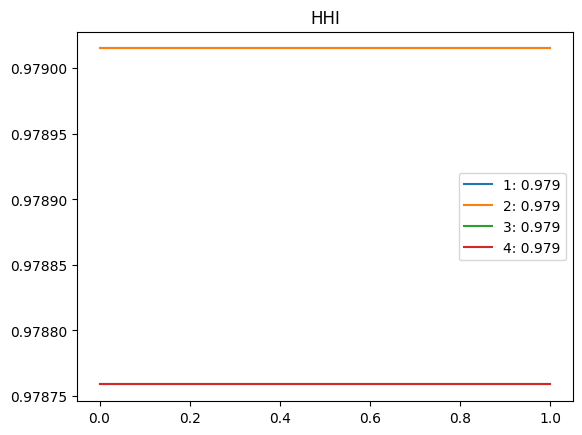

In [37]:
meas = "HHI"

data = ntwk1.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"1: {round(data,3)}")

data = ntwk2.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"2: {round(data,3)}")

data = ntwk3.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"3: {round(data,3)}")

data = ntwk4.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"4: {round(data,3)}")

plt.title(meas)
plt.legend()
plt.show()

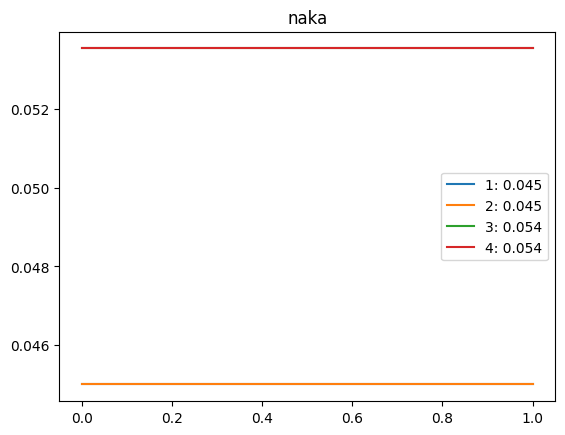

In [38]:
meas = "naka"

data = ntwk1.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"1: {round(data,3)}")

data = ntwk2.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"2: {round(data,3)}")

data = ntwk3.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"3: {round(data,3)}")

data = ntwk4.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"4: {round(data,3)}")

plt.title(meas)
plt.legend()
plt.show()

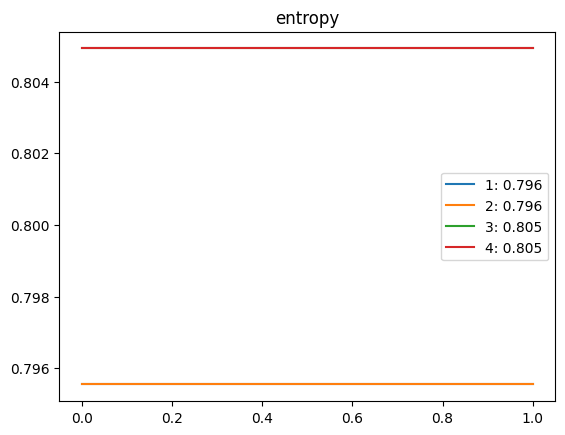

In [39]:
meas = "entropy"

data = ntwk1.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"1: {round(data,3)}")

data = ntwk2.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"2: {round(data,3)}")

data = ntwk3.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"3: {round(data,3)}")

data = ntwk4.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"4: {round(data,3)}")

plt.title(meas)
plt.legend()
plt.show()

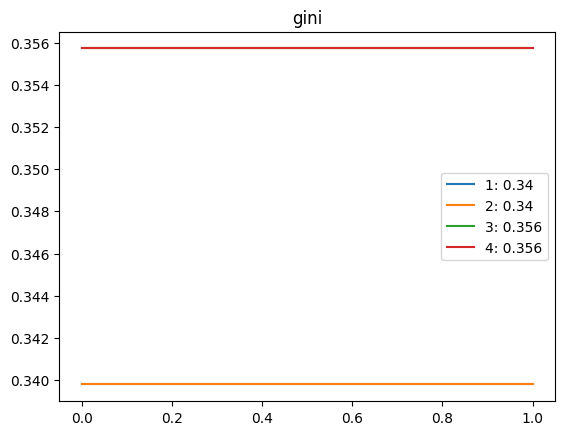

In [40]:
meas = "gini"

data = ntwk1.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"1: {round(data,3)}")

data = ntwk2.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"2: {round(data,3)}")

data = ntwk3.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"3: {round(data,3)}")

data = ntwk4.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"4: {round(data,3)}")

plt.title(meas)
plt.legend()
plt.show()

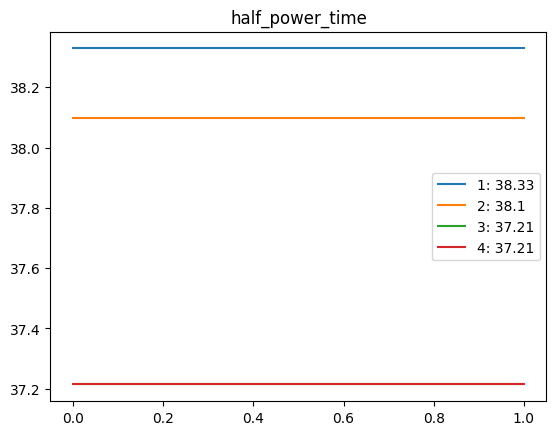

In [41]:
meas = "half_power_time"

data = ntwk1.getMeasures()[meas]
plt.plot([0,1], [1000/data, 1000/data], label=f"1: {round(1000/data,2)}")

data = ntwk2.getMeasures()[meas]
plt.plot([0,1], [1000/data, 1000/data], label=f"2: {round(1000/data,2)}")

data = ntwk3.getMeasures()[meas]
plt.plot([0,1], [1000/data, 1000/data], label=f"3: {round(1000/data,2)}")

data = ntwk4.getMeasures()[meas]
plt.plot([0,1], [1000/data, 1000/data], label=f"4: {round(1000/data,2)}")

plt.title(meas)
plt.legend()
plt.show()

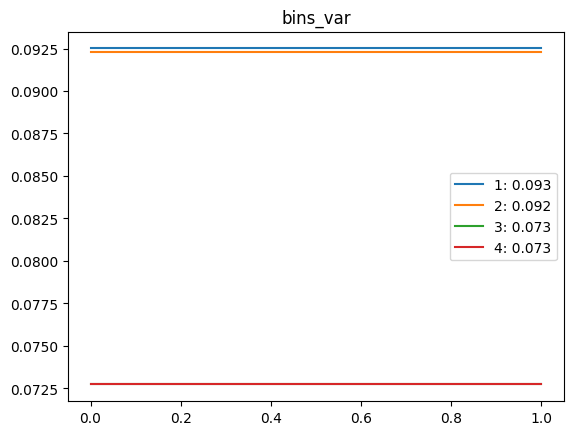

In [42]:
meas = "bins_var"

data = ntwk1.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"1: {round(data,3)}")

data = ntwk2.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"2: {round(data,3)}")

data = ntwk3.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"3: {round(data,3)}")

data = ntwk4.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"4: {round(data,3)}")

plt.title(meas)
plt.legend()
plt.show()

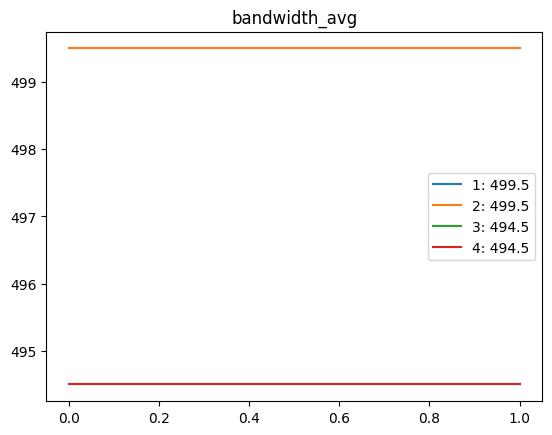

In [43]:
meas = "bandwidth_avg"

data = ntwk1.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"1: {round(data,3)}")

data = ntwk2.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"2: {round(data,3)}")

data = ntwk3.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"3: {round(data,3)}")

data = ntwk4.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"4: {round(data,3)}")

plt.title(meas)
plt.legend()
plt.show()

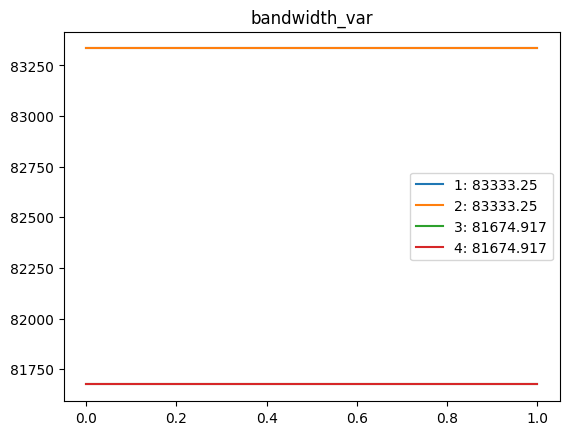

In [44]:
meas = "bandwidth_var"

data = ntwk1.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"1: {round(data,3)}")

data = ntwk2.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"2: {round(data,3)}")

data = ntwk3.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"3: {round(data,3)}")

data = ntwk4.getMeasures()[meas]
plt.plot([0,1], [data, data], label=f"4: {round(data,3)}")

plt.title(meas)
plt.legend()
plt.show()

# PoW Measures

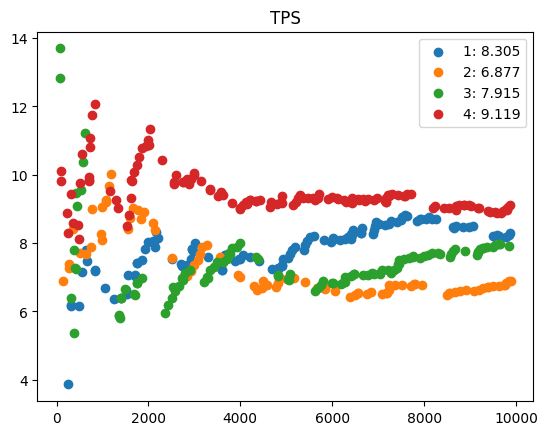

In [49]:
meas = "TPS"

data = np.array(sim1.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"1: {round(data[:,1][-1],3)}")

data = np.array(sim2.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"2: {round(data[:,1][-1],3)}")

data = np.array(sim3.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"3: {round(data[:,1][-1],3)}")

data = np.array(sim4.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"4: {round(data[:,1][-1],3)}")

plt.title(meas)
plt.legend()
plt.show()

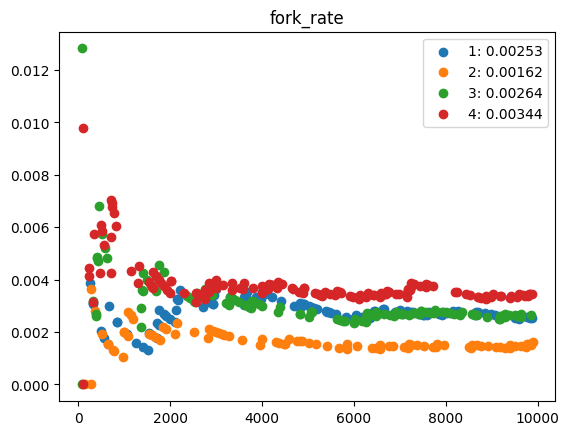

In [48]:
meas = "fork_rate"

data = np.array(sim1.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"1: {round(data[:,1][-1],5)}")

data = np.array(sim2.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"2: {round(data[:,1][-1],5)}")

data = np.array(sim3.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"3: {round(data[:,1][-1],5)}")

data = np.array(sim4.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"4: {round(data[:,1][-1],5)}")

plt.title(meas)
plt.legend()
plt.show()

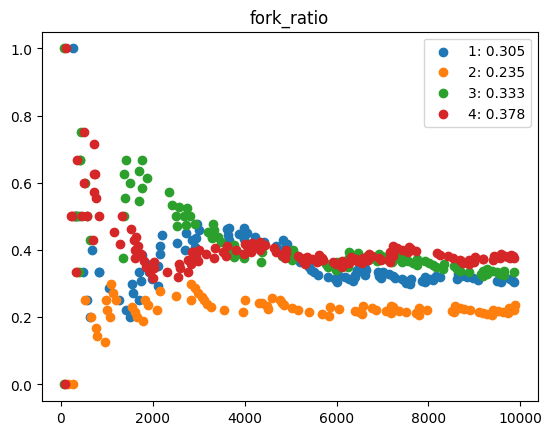

In [47]:
meas = "fork_ratio"

data = np.array(sim1.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"1: {round(data[:,1][-1],3)}")

data = np.array(sim2.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"2: {round(data[:,1][-1],3)}")

data = np.array(sim3.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"3: {round(data[:,1][-1],3)}")

data = np.array(sim4.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"4: {round(data[:,1][-1],3)}")

plt.title(meas)
plt.legend()
plt.show()

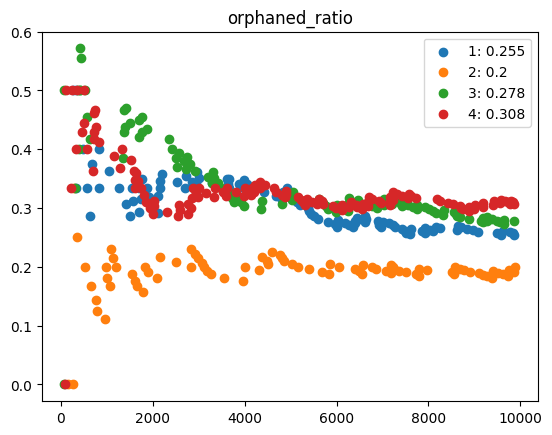

In [50]:
meas = "orphaned_ratio"

data = np.array(sim1.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"1: {round(data[:,1][-1],3)}")

data = np.array(sim2.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"2: {round(data[:,1][-1],3)}")

data = np.array(sim3.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"3: {round(data[:,1][-1],3)}")

data = np.array(sim4.measures[meas])
plt.scatter(data[:,0], data[:,1], label=f"4: {round(data[:,1][-1],3)}")

plt.title(meas)
plt.legend()
plt.show()

# Networks Collection

## Big Networks

In [5]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [6]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

{'ntwk_max_power_shares': [0.09037551634691969,
  0.07761620426052958,
  0.04508584277247456,
  0.04447505406932666,
  0.026145887041486165],
 'ntwk_min_power_shares': [0.00019375369451357776,
  0.00019402477192134127,
  0.00019406491318619997,
  0.00019424725741121044,
  0.00019433639668208792],
 'ntwk_max_bandwidth': [48833.00046773377,
  29328.114150154004,
  26831.53534281743,
  24434.026851372113,
  23097.07037310115],
 'ntwk_min_bandwidth': [8.393439314543063,
  8.493628420136085,
  8.499902190811307,
  8.54401408541276,
  8.54977560944329]}

In [7]:
nt1.getMeasures()

{'HHI': 0.9790151003020433,
 'naka': 0.045,
 'entropy': 0.7955458215337511,
 'gini': 0.3397924197386957,
 'half_power_bandwidth': 26.09010423261438,
 'bins_var': 0.0925020300677701,
 'bandwidth_avg': 499.5,
 'bandwidth_std': 288.6749902572095}

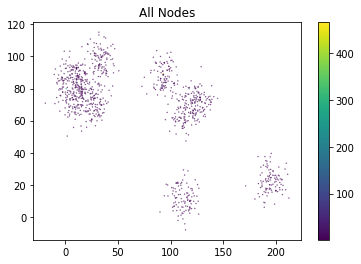

In [8]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 2000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

In [ ]:
ntp1 = {
    "n" : 1000,
    "n_clusters" : 10,
    "std" : 7,
    "pareto_param" : 1.2,
    "bandwidth_factor" : 2000,
}
nts1 = {
    "uniform_scatter" : 274,
    "normal_subscatter" : 826,
    "power" : 576,
}

In [ ]:
nt1 = ClusNtwkTriInqGenerator(ntp1, nts1)
nt1.createNetwork()
nt1.getStats()

In [ ]:
nt1.getMeasures()

In [ ]:
nt1.plotAll()

## Small Networks

# Results 1

- Set around 5 to 10 different parameters and 5 to 10 different networks
- For various combinations, run 10 to 20 simulations with random seeds and average out the results to plot
- Verify the tradeoff between scalability, decentralization and security

# Results 2

- Verify the expectation fork rate value with simulation results
- Generate around 30 small networks with around 10 to 20 nodes
- Set around 10 different parameters with varying values
- For various combinations, run around 10 simulations with random seeds and average out the fork rate
- Verify that the average fork rate for each is close enough to the expectation fork rate for that network

# Results 3

- We do know that the fork rate is proportional to $e^{-\text{TPS}}$
- Generate around 30 networks with 1000 to 5000 nodes
- Set around 10 different parameters with varying values
- For each various combinations, run around 10 simulations with random seeds and average out the fork rate
- Verify that the average fork rate is proportional to $e^{-\text{TPS}}$

# PoW Blockchain Simulator

In [3]:
class PoW:

    def __init__(self, ntwk, params, seeds):
        self.ntwk = ntwk
        self.params = params
        self.time = 0
        self.longest_chain_latest_block = 0
        self.modified_blockchain = False
        self.longest_chain = [0]
        # Is the prev_block = 0 important here?
        self.global_blockchain = {0: {"level": 0, "prev_block": 0, "miner": -1, "time_created": 0, "n_transactions": 0, "children" : []}}
        self.global_levels = {0: [0]}
        self.total_power = sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())
        self.N = len(self.ntwk.nodes())
        self.newest_block_id = 0
        #self.transaction_pool = 0
        self.signals = {}
        self.changed_blockchain_nodes = []
        self.measures = {
            "TPS" : [],
            "storage_ratio" : [],
            "fork_rate" : [],
            "fork_ratio" : [],
            "orphaned_ratio" : [],
            "consensus" : [],
            "percent_mining_longest_chain" : []
        }
        #self.rng_poisson_noise = np.random.default_rng(seeds["poisson_noise"])
        #self.rng_poisson_new_transactions = np.random.default_rng(seeds["poisson_new_transactions"])
        self.rng_exponential_minetime = np.random.default_rng(seeds["exponential_minetime"])

    def randomSignalNoise(self):
        # Random Noise CANNOT be negative
        return self.rng_poisson_noise.poisson(self.params["avg_signal_noise"])

    def addNewTransactions(self):
        self.transaction_pool += self.rng_poisson_new_transactions.poisson(self.params["avg_transaction_rate"])

    # Create number of transactions for nodes to add to the block they're mining on
    def getNumTransactions(self):
        return self.params["max_n_transactions"]
        #return max(1, min(self.transaction_pool, self.params["max_n_transactions"]))

    def sendSignal(self, node, block_id):
        # Send signal to all neighbors of node
        for nb in self.ntwk.neighbors(node):
            # Calculate arrival time of signal for neighbor "nb"
            # I have REMOVED randomSignalNoise for NOW
            arrival_time = self.time + math.ceil(self.global_blockchain[block_id]["n_transactions"]/self.ntwk[node][nb]["bandwidth"])

            # Handle missing arrival_time and nb cases
            if not (arrival_time in self.signals):
                self.signals[arrival_time] = {}
            if not (nb in self.signals[arrival_time]):
                self.signals[arrival_time][nb] = []

            # Add block_id in "arrival_time" at correct neighbor "nb"
            self.signals[arrival_time][nb].append(block_id)

    # Adds the new block to both global and node's local blockchain and updates both global and node's local levels
    def addNewBlock(self, node):
        # Level to add newly mined block = Level of block that node was mining on + 1
        level = self.global_blockchain[self.ntwk.nodes[node]["mining"]["block_id"]]["level"] + 1
        # or, as it better be mining on longest chain block, level = max(list(self.ntwk.nodes[node]["local_levels"])) + 1

        # Creates new block and updates global_blockchain
        self.global_blockchain[self.newest_block_id] = {"level": level, "prev_block": self.ntwk.nodes[node]["mining"]["block_id"], "miner": node, "time_created": self.time, "n_transactions": self.ntwk.nodes[node]["mining"]["n_transactions"], "children" : []}
        
        # Subtract n_transactions away from transaction_pool - not needed anymore after transaction_pool removed
        #self.transaction_pool -= self.ntwk.nodes[node]["mining"]["n_transactions"]

        # Adds itself to the "children" of its prev_block
        self.global_blockchain[self.ntwk.nodes[node]["mining"]["block_id"]]["children"].append(self.newest_block_id)
        
        # Updates global_levels
        if not (level in self.global_levels):
            self.global_levels[level] = []
        self.global_levels[level].append(self.newest_block_id)

        # Updates local_blockchain
        self.ntwk.nodes[node]["local_blockchain"][self.newest_block_id] = self.time

        # Updates local_levels (note that the condition must always be true, but I still added the "if" condition just in case)
        if not (level in self.ntwk.nodes[node]["local_levels"]):
            self.ntwk.nodes[node]["local_levels"][level] = []
        self.ntwk.nodes[node]["local_levels"][level].append(self.newest_block_id)

        # Adds node to changed_blockchain_nodes
        self.changed_blockchain_nodes.append(node)

    def verifyAddingBlockToNode(self, node, level, block_id) -> bool:
        if (level - 1) in self.ntwk.nodes[node]["local_levels"]:
            for block in self.ntwk.nodes[node]["local_levels"][level - 1]:
                if block == self.global_blockchain[block_id]["prev_block"]:
                    return True
        return False

    # CHANGE LOCAL BLOCKCHAIN TO ONLY HAVE BLOCK ID AND TIME IT RECEIVED IT
    def addBlockToLocalBlockchainFromSignal(self, node, block_id):
        level = self.global_blockchain[block_id]["level"]

        if self.verifyAddingBlockToNode(node, level, block_id):
            self.ntwk.nodes[node]["local_blockchain"][block_id] = self.time

            if not (level in self.ntwk.nodes[node]["local_levels"]):
                self.ntwk.nodes[node]["local_levels"][level] = []
            self.ntwk.nodes[node]["local_levels"][level].append(block_id)
            
            # Adds node to changed_blockchain_nodes
            self.changed_blockchain_nodes.append(node)

        else: # Adds block_id to storage with correct level key
            if not (level in self.ntwk.nodes[node]["storage"]):
                self.ntwk.nodes[node]["storage"][level] = []
            self.ntwk.nodes[node]["storage"][level].append(block_id)
            # Adding this node to changed_blockchain_nodes after a block has been added into its storage is unnecessary.
            # If and when a storage block does finally find a place to fit into the local blockchain,
            # That would only happen after the local blockchain has been changed by some block getting added in it,
            # And in that case, the node would be added into changed_blockchain_nodes anyway and the storage would get fixed.

    def tryAddBlockToLocalBlockchainFromStorage(self, node, level, block_id):
        if self.verifyAddingBlockToNode(node, level, block_id):
            self.ntwk.nodes[node]["local_blockchain"][block_id] = self.time

            if not (level in self.ntwk.nodes[node]["local_levels"]):
                self.ntwk.nodes[node]["local_levels"][level] = []
            self.ntwk.nodes[node]["local_levels"][level].append(block_id)
            
            # Adds node to changed_blockchain_nodes
            self.changed_blockchain_nodes.append(node)

            self.ntwk.nodes[node]["storage"][level].remove(block_id)
            
    # Handles mining
    def allMining(self):
        for node in self.ntwk.nodes():
            # Checks mining status of "node"
            if self.time == self.ntwk.nodes[node]["mining"]["mine_time"]:
                # Increase newest block id by 1 and make modified_blockchain True
                self.newest_block_id += 1
                self.modified_blockchain = True
                # Add new block to global and local blockchains
                self.addNewBlock(node)
                # Send signal to all neighbors
                self.sendSignal(node, self.newest_block_id)

    def handleSignals(self):
        # If there exist signals supposed to arrive at current time
        if self.time in self.signals:
            # For all nodes supposed to receive those signals
            for node in self.signals[self.time]:
                # Add all blocks that the particular node was supposed to receive to the node local blockchain
                for block_id in self.signals[self.time][node]:
                    self.addBlockToLocalBlockchainFromSignal(node, block_id)
            # Free up memory by deleting the current time signals list
            del self.signals[self.time]

    # For a node, checks all block ids in storage and tries to add them in local blockchain
    def checkNodeStorage(self, node):
        levels = list(self.ntwk.nodes[node]["storage"].keys())
        levels.sort()
        for level in levels:
            for block_id in self.ntwk.nodes[node]["storage"][level]:
                self.tryAddBlockToLocalBlockchainFromStorage(node, level, block_id)

    # Checks if a node is mining on the longest chain block, and restarts it if it is not
    def checkNodeRestart(self, node):
        highest_level = max(list(self.ntwk.nodes[node]["local_levels"]))
        longest_chain_block_id = self.ntwk.nodes[node]["local_levels"][highest_level][0]

        # If the block it is mining on isn't longest_chain_block_id, then restart mining on this new block
        if self.ntwk.nodes[node]["mining"]["block_id"] != longest_chain_block_id:
            self.ntwk.nodes[node]["mining"]["block_id"] = longest_chain_block_id
            t = self.time + round(self.rng_exponential_minetime.exponential(self.params["avg_mine_time"] * self.total_power/self.ntwk.nodes[node]["power"]))
            self.ntwk.nodes[node]["mining"]["mine_time"] = t
            self.ntwk.nodes[node]["mining"]["n_transactions"] = self.getNumTransactions()

    # Restarts a node forcefully
    def restartNode(self, node):
        highest_level = max(list(self.ntwk.nodes[node]["local_levels"]))
        longest_chain_block_id = self.ntwk.nodes[node]["local_levels"][highest_level][0]
        self.ntwk.nodes[node]["mining"]["block_id"] = longest_chain_block_id
        t = self.time + round(self.rng_exponential_minetime.exponential(self.params["avg_mine_time"] * self.total_power/self.ntwk.nodes[node]["power"]))
        self.ntwk.nodes[node]["mining"]["mine_time"] = t
        self.ntwk.nodes[node]["mining"]["n_transactions"] = self.getNumTransactions()

    # For every changed blockchain nodes, checks its storage and whether it requires restart
    def checkNodes(self):
        for _ in range(len(self.changed_blockchain_nodes)):
            # Pop the node out to free up memory
            node = self.changed_blockchain_nodes.pop(0)
            self.checkNodeStorage(node)
            self.checkNodeRestart(node)
    
    def changeLongestChainAndLatestBlock(self):
        self.longest_chain.clear()

        self.longest_chain_latest_block = self.global_levels[max(list(self.global_levels))][0]

        # Get longest chain's latest block id, which is the first block in the highest global level
        block_id = self.longest_chain_latest_block

        # WHY WAS THIS WRITTEN IN PLACE OF ABOVE BEFORE? IT HAS LOCAL LEVELS NOT GLOBAL, AND node VARIABLE ISN'T EVEN DEFINED
        # block_id = self.ntwk.nodes[node]["local_levels"][max(list(self.global_levels))][0]

        while block_id != 0:
            self.longest_chain.append(block_id)
            block_id = self.global_blockchain[block_id]["prev_block"]

    def measureTPS(self):
        # self.time will not be 0 as it is incremented to 1 at the start of the very first iteration
        return sum(self.global_blockchain[block_id]["n_transactions"] for block_id in self.longest_chain)/self.time

    # Ratio of total number of blocks in storage across all nodes to total number of blocks
    def measureStorageRatio(self):
        if self.newest_block_id == 0 : return 0
        return sum(len(self.ntwk.nodes[node]["storage"][level]) for node in self.ntwk.nodes() for level in self.ntwk.nodes[node]["storage"])/self.newest_block_id

    # Two measures - Rate of forks; and Ratio of number of forks to total number of blocks
    def measureForkRateAndRatio(self):
        if self.newest_block_id == 0 : return {"rate" : 0, "ratio" : 0}
        func = lambda l : l - 1 if l >= 2 else 0
        forks = sum(func(len(self.global_blockchain[block_id]["children"])) for block_id in self.global_blockchain)
        return {"rate" : forks/self.time, "ratio" : forks/len(self.longest_chain)}

    # Ratio of number of orphaned blocks to total number of blocks
    def measureOrphanedBlocksRatio(self):
        if self.newest_block_id == 0 : return 0
        return (self.newest_block_id - len(self.longest_chain))/self.newest_block_id

    # Measure the distribution of lengths of chains that have been reverted and abandoned
    def measureRevertRate(self):
        pass

    # Check the consensus on blockchain - till when do they all agree and by how much?
    def measureConsensus(self):
        num_nodes_mining_on_block = {}
        for node in self.ntwk.nodes():
            if not (self.ntwk.nodes[node]["mining"]["block_id"] in num_nodes_mining_on_block):
                num_nodes_mining_on_block[self.ntwk.nodes[node]["mining"]["block_id"]] = 0
            num_nodes_mining_on_block[self.ntwk.nodes[node]["mining"]["block_id"]] += 1
        return sum((num_nodes_mining_on_block[block_id]/self.N)**2 for block_id in num_nodes_mining_on_block)

    def measurePercentMiningOnLongestChain(self):
        return sum((self.ntwk.nodes[node]["mining"]["block_id"] == self.longest_chain_latest_block) for node in self.ntwk.nodes())/self.N

    def runMeasures(self):
        #self.measures["storage_ratio"].append((self.time, self.measureStorageRatio()))
        #self.measures["consensus"].append((self.time, self.measureConsensus()))
        #self.measures["percent_mining_longest_chain"].append((self.time, self.measurePercentMiningOnLongestChain()))
        if self.modified_blockchain:
            # First change the longest chain and latest block
            self.changeLongestChainAndLatestBlock()
            # Then calculate the measures
            self.measures["TPS"].append((self.time, self.measureTPS()))
            fork_measures = self.measureForkRateAndRatio()
            self.measures["fork_rate"].append((self.time, fork_measures["rate"]))
            self.measures["fork_ratio"].append((self.time, fork_measures["ratio"]))
            self.measures["orphaned_ratio"].append((self.time, self.measureOrphanedBlocksRatio()))
            # Set modified_blockchain back to False
            self.modified_blockchain = False

    def initializeNetwork(self):
        for node in self.ntwk.nodes():
            self.ntwk.nodes[node]["mining"] = {}
            self.ntwk.nodes[node]["mining"]["block_id"] = 0
            t = self.time + round(self.rng_exponential_minetime.exponential(self.params["avg_mine_time"] * self.total_power/self.ntwk.nodes[node]["power"]))
            self.ntwk.nodes[node]["mining"]["mine_time"] = t
            self.ntwk.nodes[node]["mining"]["n_transactions"] = self.getNumTransactions()
            self.ntwk.nodes[node]["local_blockchain"] = {0: 0}
            self.ntwk.nodes[node]["local_levels"] = {0: [0]}
            self.ntwk.nodes[node]["storage"] = {}

    def runSimulation(self):
        self.allminingtime = 0
        self.handlesignalstime = 0
        #self.addnewtranstime = 0
        self.runmeasurestime = 0
        self.checknodestime = 0
        #self.addNewTransactions()
        self.initializeNetwork()
        while (self.time < self.params["run_time"]):
            self.time += 1
            #s = time.time()
            #self.addNewTransactions()
            #e = time.time()
            #self.addnewtranstime += e - s
            s = time.time()
            self.allMining()
            e = time.time()
            self.allminingtime += e - s
            s = time.time()
            self.handleSignals()
            e = time.time()
            self.handlesignalstime += e - s
            # self.measures() should go here as self.checkNodes() deletes some data like storage that self.measure() might need
            s = time.time()
            self.runMeasures()
            e = time.time()
            self.runmeasurestime += e - s
            s = time.time()
            self.checkNodes()
            e = time.time()
            self.checknodestime += e - s

# Network Generator

In [ ]:
class UniRnNtwkTriInqGenerator:

    def __init__(self, params, seeds):
        self.params = params
        self.ntwk = nx.complete_graph(self.params["n"])
        self.seeds = seeds

    def generateScatter(self):
        rng_uniform_scatter = np.random.default_rng(self.seeds["scatter"])
        self.X = rng_uniform_scatter.uniform(size=(self.params["n"], 2))

    def assignPower(self):
        rng_pareto_power = np.random.default_rng(self.seeds["power"])
        for i in range(self.params["n"]):
            self.ntwk.nodes[i]["power"] = rng_pareto_power.pareto(self.params["pareto_param"]) + 1
        self.total_power = sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())

    def assignBandwidth(self):
        for i in range(self.params["n"] - 1):
            for j in range(i + 1, self.params["n"]):
                self.ntwk[i][j]["bandwidth"] = self.params["bandwidth_factor"]/np.linalg.norm(self.X[i] - self.X[j])

    def assignActivity(self):
        rng_uniform_activity = np.random.default_rng(self.seeds["activity"])
        for i in range(self.params["n"]):
            self.ntwk.nodes[i]["active"] = (rng_uniform_activity.uniform() < self.params["active_prob"])

    def plotAll(self):
        plt.scatter(self.X[:,0], self.X[:,1], c=[self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes])
        plt.title("All Nodes")
        plt.colorbar()
        plt.show()

    def getStats(self):
        stats = {}
        stats["ntwk_total_power"] = self.total_power
        stats["ntwk_max_powers"] = heapq.nlargest(5, (self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()))
        stats["ntwk_max_power_shares"] = heapq.nlargest(5, (self.ntwk.nodes[node]["power"]/self.total_power for node in self.ntwk.nodes()))
        stats["ntwk_min_powers"] = heapq.nsmallest(5, (self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()))
        stats["ntwk_min_power_shares"] = heapq.nsmallest(5, (self.ntwk.nodes[node]["power"]/self.total_power for node in self.ntwk.nodes()))
        stats["ntwk_max_bandwidth"] = heapq.nlargest(5, (self.ntwk.edges[edge]["bandwidth"] for edge in self.ntwk.edges()))
        stats["ntwk_min_bandwidth"] = heapq.nsmallest(5, (self.ntwk.edges[edge]["bandwidth"] for edge in self.ntwk.edges()))
        return stats

    def measureHHI(self):
        return 1 - sum((power/self.total_power)**2 for power in heapq.nlargest(math.ceil(len(self.ntwk)*10/100), (self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())))

    def measureNaka(self):
        power_values = [self.ntwk.nodes[node]["power"]/self.total_power for node in self.ntwk.nodes()]
        power_values.sort(reverse=True)
        power_sum = 0
        num = 0
        while (power_sum < 0.51):
            power_sum += power_values[num]
            num += 1
        return num/len(self.ntwk)

    def measureEntropy(self):
        return -float(sum((self.ntwk.nodes[node]["power"]/self.total_power) * np.log2(self.ntwk.nodes[node]["power"]/self.total_power) for node in self.ntwk.nodes())/np.log2(len(self.ntwk)))

    def measureGini(self):
        power_values = [self.ntwk.nodes[node]["power"]/self.total_power for node in self.ntwk.nodes()]
        gini = 0
        for i in range(len(self.ntwk) - 1):
            for j in range(i + 1, len(self.ntwk)):
                gini += abs(power_values[i] - power_values[j])
        return 1 - gini/len(self.ntwk)

    def calcMeasures(self):
        self.measures = {}
        self.measures["HHI"] = self.measureHHI()
        self.measures["naka"] = self.measureNaka()
        self.measures["entropy"] = self.measureEntropy()
        self.measures["gini"] = self.measureGini()

    def getMeasures(self):
        return self.measures

    def createNetwork(self):
        self.generateScatter()
        self.assignPower()
        self.assignBandwidth()
        self.calcMeasures()
        # self.assignActivity()

    def getNetwork(self):
        return self.ntwk

In [4]:
class ClusNtwkTriInqGenerator:

    def __init__(self, params, seeds):
        self.params = params
        self.seeds = seeds

    def generateScatter(self):
        rng_uniform_scatter = np.random.default_rng(self.seeds["uniform_scatter"])
        rng_normal_scatter = np.random.default_rng(self.seeds["normal_subscatter"])
        cluster_centers = rng_uniform_scatter.uniform(low=(0,0), high=(200,100), size=(self.params["n_clusters"], 2))
        firstval = True
        for center in cluster_centers:
            points = rng_normal_scatter.normal(loc=center, scale=self.params["std"], size=(round(self.params["n"]/self.params["n_clusters"]), 2))
            if firstval:
                self.X = points
                firstval = False
            else:
                self.X = np.concatenate((self.X, points))
        self.ntwk = nx.complete_graph(len(self.X))

    def assignPower(self):
        rng_pareto_power = np.random.default_rng(self.seeds["power"])
        for i in range(len(self.ntwk)):
            self.ntwk.nodes[i]["power"] = rng_pareto_power.pareto(self.params["pareto_param"]) + 1
        self.total_power = sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())

    def assignBandwidth(self):
        for i in range(len(self.ntwk) - 1):
            for j in range(i + 1, len(self.ntwk)):
                if np.linalg.norm(self.X[i] - self.X[j]) == 0:
                    print(self.X[i], self.X[j])
                    print(i,j)
                self.ntwk[i][j]["bandwidth"] = self.params["bandwidth_factor"]/np.linalg.norm(self.X[i] - self.X[j])

    def plotAll(self):
        plt.scatter(self.X[:,0], self.X[:,1], c=[self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes], s=0.1)
        plt.title("All Nodes")
        plt.colorbar()
        plt.show()

    def getStats(self):
        stats = {}
        stats["ntwk_max_power_shares"] = heapq.nlargest(5, (self.ntwk.nodes[node]["power"]/self.total_power for node in self.ntwk.nodes()))
        stats["ntwk_min_power_shares"] = heapq.nsmallest(5, (self.ntwk.nodes[node]["power"]/self.total_power for node in self.ntwk.nodes()))
        stats["ntwk_max_bandwidth"] = heapq.nlargest(5, (self.ntwk.edges[edge]["bandwidth"] for edge in self.ntwk.edges()))
        stats["ntwk_min_bandwidth"] = heapq.nsmallest(5, (self.ntwk.edges[edge]["bandwidth"] for edge in self.ntwk.edges()))
        #stats["ntwk_total_power"] = self.total_power
        #stats["ntwk_max_powers"] = heapq.nlargest(5, (self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()))
        #stats["ntwk_min_powers"] = heapq.nsmallest(5, (self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()))
        return stats

    def measureHHI(self):
        return 1 - sum((power/self.total_power)**2 for power in heapq.nlargest(math.ceil(len(self.ntwk)*10/100), (self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())))

    def measureNaka(self):
        power_values = [self.ntwk.nodes[node]["power"]/self.total_power for node in self.ntwk.nodes()]
        power_values.sort(reverse=True)
        power_sum = 0
        num = 0
        while (power_sum < 0.51):
            power_sum += power_values[num]
            num += 1
        return num/len(self.ntwk)

    def measureEntropy(self):
        return -float(sum((self.ntwk.nodes[node]["power"]/self.total_power) * np.log2(self.ntwk.nodes[node]["power"]/self.total_power) for node in self.ntwk.nodes())/np.log2(len(self.ntwk)))

    def measureGini(self):
        power_values = [self.ntwk.nodes[node]["power"]/self.total_power for node in self.ntwk.nodes()]
        gini = 0
        for i in range(len(self.ntwk) - 1):
            for j in range(i + 1, len(self.ntwk)):
                gini += abs(power_values[i] - power_values[j])
        return 1 - gini/len(self.ntwk)

    def measureBinsVar(self):
        bin_size = self.params["std"]/5

        min_x = min(point[0] for point in self.X)
        min_y = min(point[1] for point in self.X)

        # Initialize the bin counts
        bin_counts = np.zeros((int((max(point[0] for point in self.X) - min_x) / bin_size) + 1, int((max(point[1] for point in self.X) - min_y) / bin_size) + 1), dtype=int)

        # Assign points to bins
        for x, y in self.X:
            bin_x = int((x - min_x) / bin_size)
            bin_y = int((y - min_y) / bin_size)
            bin_counts[bin_x, bin_y] += 1

        # Flatten the bin counts and calculate the variance
        return np.var(bin_counts.flatten())

    def forkPMFNode(self, nf, node_i, TPS):
        prob = 0
        nodes = list(self.ntwk.nodes())
        nodes.remove(node_i)
        for comb in itertools.combinations(nodes, len(self.ntwk) - 1 - nf):
            exponent = 0
            for node_j in comb:
                exponent += self.ntwk.nodes[node_j]["power"]/(self.total_power * self.ntwk[node_i][node_j]["bandwidth"])
            subprob = math.exp(- TPS * exponent)
            for node_j in nodes:
                if node_j in comb: continue
                subprob *= (1 - math.exp(- TPS * self.ntwk.nodes[node_j]["power"]/(self.total_power * self.ntwk[node_i][node_j]["bandwidth"])))
            prob += subprob
        return prob

    def forkPMF(self, nf, TPS):
        if nf < 0 or nf >= len(self.ntwk):
            return 0
        prob = 0
        for node in self.ntwk.nodes():
            prob += (self.ntwk.nodes[node]["power"] * self.forkPMFNode(nf, node, TPS))/self.total_power
        return prob

    # TERRIBLY EXPONENTIALLY LONG FUNCTION - NEVER RUN IT
    def measureForkRateAvgVar(self, TPS):
        E1, E2 = 0, 0
        for nf in range(0, len(self.ntwk)):
            pmf = self.forkPMF(nf, TPS)
            E1 += nf * pmf
            E2 += (nf ** 2) * pmf
        return (E1, E2 - (E1 ** 2))

    def measureBandwidthAvg(self):
        return np.mean(self.ntwk.edges)

    def measureBandwidthStd(self):
        return np.std(self.ntwk.edges)

    def measureHalfPowerTimeNode(self, node):
        nbs = sorted(self.ntwk[node].items(), reverse=True, key = lambda item : item[1]["bandwidth"])
        cumulative_power = 0
        for nb, edge_data in nbs:
            cumulative_power += self.ntwk.nodes[nb]["power"]
            if cumulative_power > self.total_power/2:
                return edge_data["bandwidth"]

    def measureHalfPowerBandwidth(self):
        avg = 0
        for node in self.ntwk.nodes():
            if self.measureHalfPowerTimeNode(node) == 0:
                print(node)
                print(self.measureHalfPowerTimeNode(node))
            avg += 1/self.measureHalfPowerTimeNode(node)
        return len(self.ntwk)/avg

    def measureHalfPowerTime(self, max_n_transactions):
        return max_n_transactions/self.measureHalfPowerBandwidth()

    def measureSumPowerByBandwidth(self, node_i):
        return sum(self.ntwk.nodes[node_j]["power"]/(self.ntwk[node_i][node_j]["bandwidth"] * self.total_power) for node_j in nx.neighbors(self.ntwk, node_i))

    def measureSumPowerByBandwidthLnPi(self):
        return sum(math.log(self.ntwk.nodes[node_i]["power"]/self.total_power) * self.measureSumPowerByBandwidth(node_i) for node_i in self.ntwk.nodes())

    def calcMeasures(self):
        self.measures = {}
        self.measures["HHI"] = self.measureHHI()
        self.measures["naka"] = self.measureNaka()
        self.measures["entropy"] = self.measureEntropy()
        self.measures["gini"] = self.measureGini()
        self.measures["half_power_bandwidth"] = self.measureHalfPowerBandwidth()
        self.measures["bins_var"] = self.measureBinsVar()
        self.measures["bandwidth_avg"] = self.measureBandwidthAvg()
        self.measures["bandwidth_std"] = self.measureBandwidthStd()
        #self.measures["sum_power_by_bandwidth_lnp"] = self.measureSumPowerByBandwidthLnPi()

    def getMeasures(self):
        return self.measures

    def createNetwork(self):
        self.generateScatter()
        self.assignPower()
        self.assignBandwidth()
        self.calcMeasures()

    def getNetwork(self):
        return self.ntwk

# Extra Stuff Below

In [12]:
pow_params1 = {
    "run_time" : 10000,
    "avg_mine_time" : 100,
    "max_n_transactions" : 500,
    "avg_signal_noise" : 5,
    "activate" : 0,
    "deactivate" : 0,
    "avg_transaction_rate" : 50
}
pow_seeds1 = {
    "poisson_noise" : 10,
    "poisson_new_transactions" : 11,
    "uniform_activity" : 12,
    "exponential_minetime" : 13
}

In [8]:
pow_params2 = {
    "run_time" : 2000,
    "avg_mine_time" : 100,
    "max_n_transactions" : 1000,
    "avg_signal_noise" : 5,
    "activate" : 0,
    "deactivate" : 0,
    "avg_transaction_rate" : 50
}
pow_seeds2 = {
    "poisson_noise" : 14,
    "poisson_new_transactions" : 15,
    "uniform_activity" : 16,
    "exponential_minetime" : 17
}

In [9]:
pow_params3 = {
    "run_time" : 2000,
    "avg_mine_time" : 100,
    "max_n_transactions" : 2000,
    "avg_signal_noise" : 5,
    "activate" : 0,
    "deactivate" : 0,
    "avg_transaction_rate" : 50
}
pow_seeds3 = {
    "poisson_noise" : 18,
    "poisson_new_transactions" : 19,
    "uniform_activity" : 20,
    "exponential_minetime" : 21
}

In [13]:
sim1 = PoW(ntwk.getNetwork().copy(), pow_params1, pow_seeds1)

In [205]:
sim2 = PoW(ntwk.getNetwork().copy(), pow_params2, pow_seeds2)

In [206]:
sim3 = PoW(ntwk.getNetwork().copy(), pow_params3, pow_seeds3)

In [14]:
sim1.runSimulation()

In [15]:
print(f"All Mining : {sim1.allminingtime}")
print(f"Handle Signals : {sim1.handlesignalstime}")
print(f"New Trans : {sim1.addnewtranstime}")
print(f"Run Measures : {sim1.runmeasurestime}")
print(f"Check Nodes : {sim1.checknodestime}")

All Mining : 2.9293127059936523
Handle Signals : 0.29334545135498047
New Trans : 0.04772019386291504
Run Measures : 10.184454917907715
Check Nodes : 0.6853699684143066


In [17]:
print(sim1.activity_changes)

0


In [208]:
sim2.runSimulation()

In [209]:
sim3.runSimulation()

In [210]:
print(sim1.activity_changes)

0


NameError: name 'sim2' is not defined

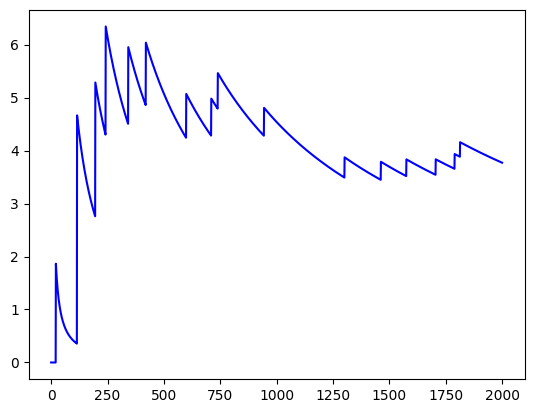

In [36]:
st = "TPS"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

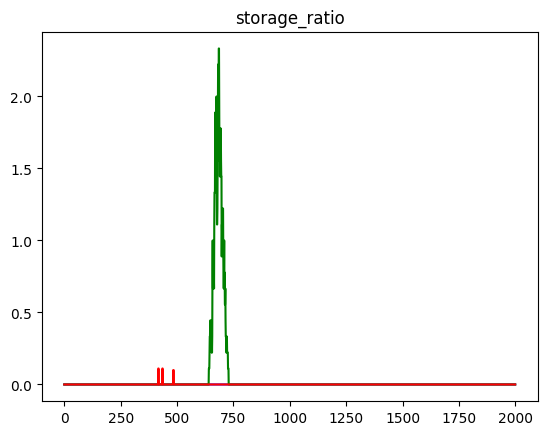

In [212]:
st = "storage_ratio"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

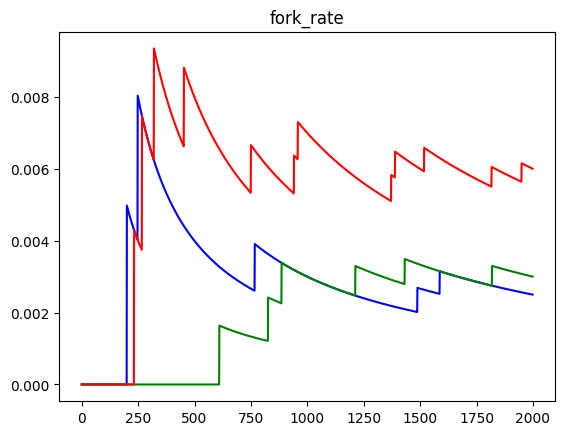

In [213]:
st = "fork_rate"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

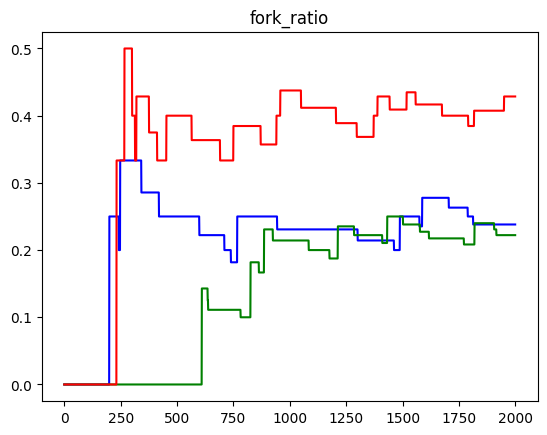

In [214]:
st = "fork_ratio"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

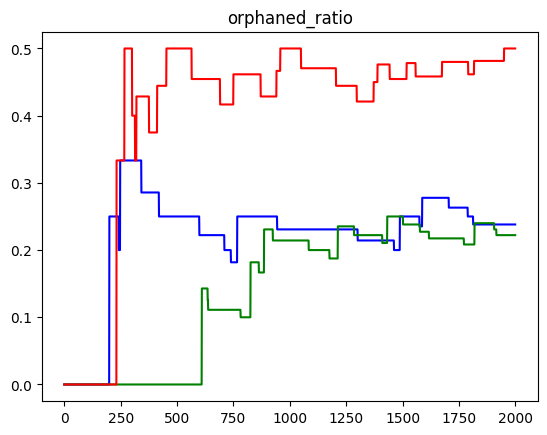

In [215]:
st = "orphaned_ratio"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

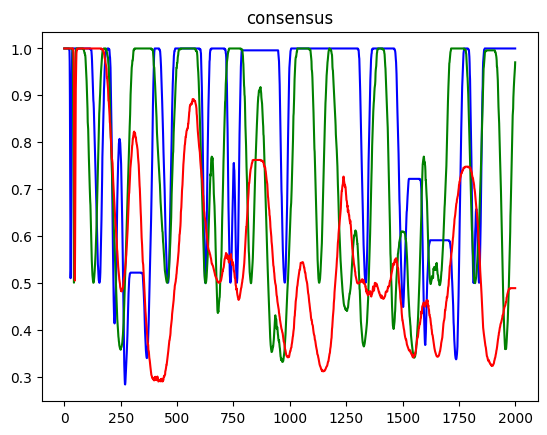

In [216]:
st = "consensus"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

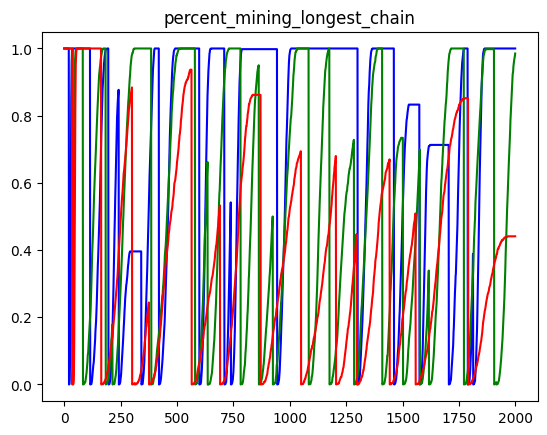

In [217]:
st = "percent_mining_longest_chain"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

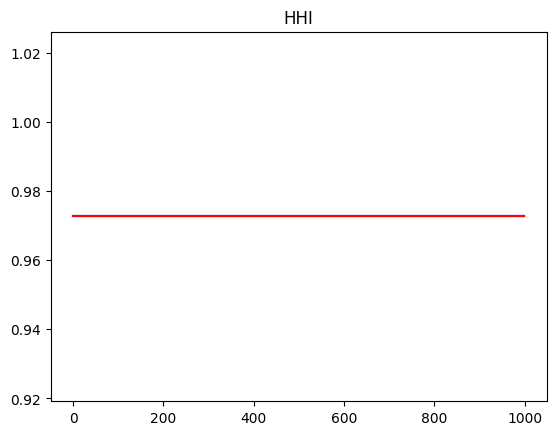

In [181]:
st = "HHI"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

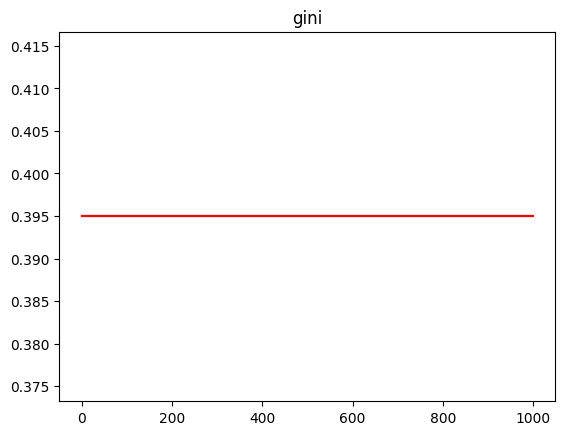

In [180]:
st = "gini"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

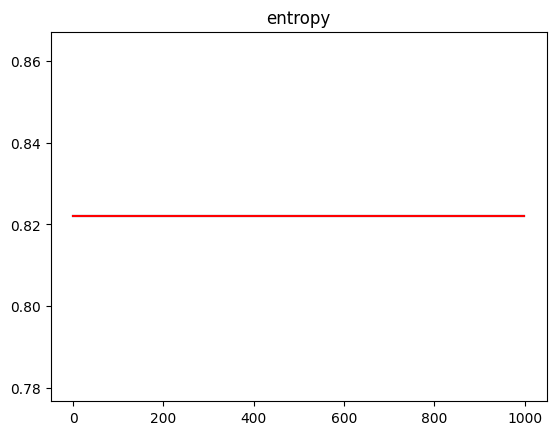

In [179]:
st = "entropy"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

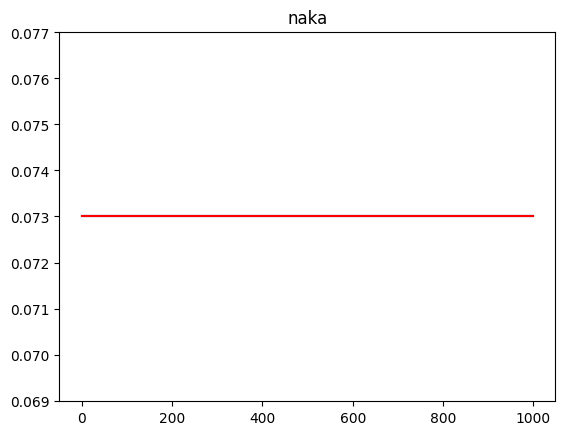

In [178]:
st = "naka"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()